In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from network import Network
from network import Trainer
from preprocessing import Preprocessing
from progressbar import ProgressBar

## Čišćenje dataSet-ova

In [2]:
preprocessing = Preprocessing()

In [4]:
# preprocessing.CheckImages("training/benign/")
# preprocessing.CheckImages("training/malignant/")

# preprocessing.CheckImages("validation/benign/")
# preprocessing.CheckImages("validation/malignant/")

# preprocessing.CheckImages("testing/benign/")
# preprocessing.CheckImages("testing/malignant/")

## Učitavanje podataka u vidu Tensora

In [3]:
trainingData = preprocessing.DataReader("training")
validationData = preprocessing.DataReader("validation")
testingData = preprocessing.DataReader("testing")

In [4]:
trainingIndicies = preprocessing.AppendIndicies(trainingData)
validationIndicies = preprocessing.AppendIndicies(validationData)
testingIndicies = preprocessing.AppendIndicies(testingData)

In [5]:
batchSize = 64

trainingDataLoader = preprocessing.DataLoader(
    trainingIndicies,
    trainingData,
    batchSize = batchSize)

validationDataLoader = preprocessing.DataLoader(
    validationIndicies,
    validationData,
    batchSize = batchSize)

testingDataLoader = preprocessing.DataLoader(
    testingIndicies,
    testingData,
    batchSize = batchSize)

## Prikaz slučajno izabranih snimaka iz sva tri dataSeta 
### Prva vizuelizacija je vizuelizacija dataSeta za trening, zatim slijedi validacioni dataSet i na kraju dataSet za testiranje

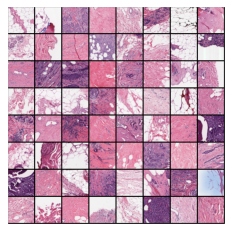

In [7]:
preprocessing.ShowGrid(trainingDataLoader)

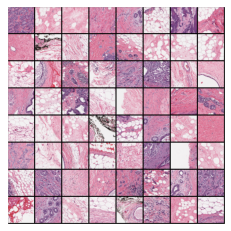

In [8]:
preprocessing.ShowGrid(validationDataLoader)

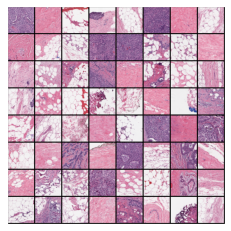

In [9]:
preprocessing.ShowGrid(testingDataLoader)

In [6]:
network = Network()
trainer = Trainer()
# epoch = 0
optimizer = optim.Adam(network.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2)

# checkpoint = torch.load(PATH)
LOAD_PATH = "../checkpoints/model22.pth"
checkpoint = torch.load(LOAD_PATH)
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

In [7]:
#epoch = 0
array = []
# optimizer = optim.Adam(network.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2)


epochs = 30
trainingArray = []
learningRate = np.array([])

for epoch in range(epoch, epochs):
    
    PATH = f"../checkpoints/model{epoch}.pth"
    trainingLoss, trainingAccuracy = 0, 0 
    valLoss, valCorret = 0, 0
    network.train()
                       
    loop = tqdm(enumerate(trainingDataLoader), total = len(trainingDataLoader), leave = False)
    for batchIndex, (images, labels) in loop:
        
        predictions = network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainingLoss += loss.item()
        trainingAccuracy += trainer.Correct(predictions, labels)
        
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(loss = loss.item(), acc = torch.rand(1).item())
    
    array.append([epoch , trainingAccuracy, trainingLoss])
    print(f"Epoch {epoch}\t Total Training Loss: {trainingLoss}\t Total Training Accuracy: {trainingAccuracy}\t Mean Training: {trainingAccuracy / len(trainingData)}")
    # Validation     
    valLoss, valCorret = trainer.Validation(network, validationDataLoader, epoch, epochs)
    scheduler.step(valLoss) # optimizing the learning rate
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'scheduler': scheduler.state_dict()
    }, PATH)    
    
    train = open("./data/training.txt", "a")
    for i in trainingArray:
        train.write(i)
    train.close()

  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 19	 Total Training Loss: 219.20704003423452	 Total Training Accuracy: 35169	 Mean Training: 0.8543630356622292


Epoch: 19	 Total Validation Loss: 24.712370738387108	 Total Validation Correct: 3304


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 20	 Total Training Loss: 222.26403826475143	 Total Training Accuracy: 35057	 Mean Training: 0.8516422116412399


Epoch: 20	 Total Validation Loss: 22.55301509797573	 Total Validation Correct: 3305


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 21	 Total Training Loss: 218.97433406114578	 Total Training Accuracy: 35172	 Mean Training: 0.854435914877077


Epoch: 21	 Total Validation Loss: 24.58134889602661	 Total Validation Correct: 3304


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 22	 Total Training Loss: 218.04803478717804	 Total Training Accuracy: 35161	 Mean Training: 0.8541686910893014


Epoch: 22	 Total Validation Loss: 22.600752040743828	 Total Validation Correct: 3313


KeyboardInterrupt: 

In [ ]:
# PATH = "./model/model.pth"
# torch.save(network.state_dict(), PATH)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(avgEpochAccuracy, label = "Training Accuracy", color = "#001024")
plt.plot(valEpochAccuracy, label = "Validation Accuracy", color = "#FF800B")
plt.title("Training and Validation Accuracy", fontsize = 14, fontweight = "bold")
plt.xlabel("Epoch", fontsize = 12, fontweight = "bold")
plt.ylabel("Value", fontsize = 12, fontweight = "bold")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
plt.legend(loc = "lower right")

sns.set_style("white")
sns.despine(top = True, right = True)

plt.show()

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(avgEpochLoss, label = "Training Loss", color = "#001024")
plt.plot(valEpochLoss, label = "Validation Loss", color = "#FF800B")
plt.title("Training and Validation Loss", fontsize = 14, fontweight = "bold")
plt.xlabel("Epoch", fontsize = 12, fontweight = "bold")
plt.ylabel("Value", fontsize = 12, fontweight = "bold")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

sns.set_style("white")
sns.despine(top = True, right = True)

plt.legend()
plt.show()

In [ ]:
trainCorrect = trainingAccuracy
trainIncorrect = len(trainingData.targets) - trainingAccuracy

In [ ]:
valCorrect = validationAccuracy
valIncorrect = len(validationData.targets) - validationAccuracy

In [ ]:
labels = ['Training', 'Validation']
plt.figure(figsize = (6,5))

sns.set_style("darkgrid")

plt.bar(
    x = labels[0],
    height = trainCorrect,
    color = "#001024",
    width = 0.12,
    align = "center",
    label = "Correct"
)

plt.bar(
    x = labels[1],
    height = valCorrect,
    color = "#001024",
    width = 0.12,
    align = "center"
)

plt.bar(
    x = labels[0],
    height = trainIncorrect,
    bottom = trainCorrect,
    color = "#FF800B",
    width = 0.12,
    align = "center"
)

plt.bar(
    x = labels[1],
    height = valIncorrect,
    bottom = valCorrect,
    color = "#FF800B",
    width = 0.12,
    label = "Incorrect",
    align = "center"
)

plt.title("Number of Correct and Incorrect Predictions\n in the Training and Validation Phase", fontsize = 14, fontweight = "bold")
plt.xlabel("Phase", fontsize = 12, fontweight = "bold")
plt.ylabel("Number of Values", fontsize = 12, fontweight = "bold")

plt.legend()
plt.show()
